In [0]:
from google.colab import drive
drive.mount('/content/drive/', True)

dataset_dir = "/content/drive/My Drive/MIIPS/Deepglobe/road-train-1.v2/"

import os
os.chdir(dataset_dir)

from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision

!ls "/content/drive/My Drive/MIIPS/Deepglobe/road-train-1.v2/"

Mounted at /content/drive/
classifier_25epoch.pth	classifier_one.pth  classifier_two.pth	valid
classifier_3epochs.pth	classifier.pth	    train


In [0]:
# !/usr/bin/nvidia-smi
!/opt/bin/nvidia-smi

In [0]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode, align_corners=self.align_corners)
        return x

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)

class AlbuNet(nn.Module):

    def __init__(self, num_classes=1, num_filters=32, pretrained=True, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes
        self.pool = nn.MaxPool2d(2, 2)
        self.encoder = torchvision.models.resnet34(pretrained=pretrained)
#         self.encoder = torchvision.models.googlenet(pretrained=pretrained)
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)
        self.conv2 = self.encoder.layer1
        self.conv3 = self.encoder.layer2
        self.conv4 = self.encoder.layer3
        self.conv5 = self.encoder.layer4

#         self.conv1 = nn.Sequential(self.encoder.conv1,
#                                    self.encoder.maxpool1,
#                                   self.encoder.conv2,
#                                   self.encoder.maxpool2)
#         self.conv2 = self.encoder.maxpool3
#         self.conv3 = self.encoder.maxpool4
#         self.conv4 = self.encoder.inception5a
#         self.conv5 = self.encoder.inception5b
        
        #                    in_channels, middle_channels,     out_channels,    is_deconv
        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = sigmoid(self.final(dec0))

        return x_out

from torch.nn import Module
from torch import sigmoid


def soft_jaccard(outputs, targets, weight=1):
    eps = 1e-15
    jaccard_target = (targets == 1).float()
    jaccard_output = sigmoid(outputs)

    intersection = (jaccard_output * jaccard_target).sum()
    union = jaccard_output.sum() + jaccard_target.sum()
    return intersection / (union - intersection + eps)


class LossBinary:

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            loss += self.jaccard_weight * (1 - soft_jaccard(outputs, targets))
        return loss

class DiceLoss:
  
  def __init__(self, dice_weight=1):
                self.nll_loss = nn.BCELoss()
                self.dice_weight = dice_weight
  
  def __call__(self, outputs, targets):
    loss = self.nll_loss(outputs, targets)
    
    if self.dice_weight:
      eps = 1e-15
      dice_target = (targets == 1).float()
      dice_output = outputs
      intersection = (dice_output * dice_target).sum()
      union = dice_output.sum() + dice_target.sum() + eps
      loss -= torch.log(2 * intersection / union)
      
      return loss

from PIL import Image

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_data = glob.glob(dataset_dir + "train/*.jpg")
folder_mask = glob.glob(dataset_dir + "train/*.png")

len_data = len(folder_data)
train_size = 0.7

train_image_paths = folder_data[:int(len_data*train_size)]
test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask[:int(len_data*train_size)]
test_mask_paths = folder_mask[int(len_data*train_size):]


class CustomDataset(Dataset):

    def __init__(self, image_paths, target_paths, train=True):
      self.image_paths = image_paths
      self.target_paths = target_paths
      self.transforms = transforms.Compose([transforms.RandomResizedCrop(size = 448, scale = (0.6, 1.4)),
                                            transforms.RandomRotation(degrees = 30),
                                            transforms.ToTensor()])
    
#       self.transforms = transforms.ToTensor()
    
    
    
    def __getitem__(self, index):
         
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index]).convert('1')
        t_image = transforms.ColorJitter(brightness=0.2,contrast=0.2,hue=0.02)(image)
        t_image = self.transforms(t_image)
#         t_image = self.transforms(image)
        t_mask = self.transforms(mask)

#         t_image = transforms.Compose([transforms.ToTensor()])(image)
#         t_mask = transforms.Compose([transforms.ToTensor()])(mask)

        
        return t_image, t_mask
    
    def __len__(self): 
        # return count of sample we have
        return len(self.image_paths)
#         return 400


train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)

print("Size of train dataset:", len(train_dataset))
print("Size of test dataset :", len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

# model = AlbuNet().to(device)
model = AlbuNet(is_deconv=False).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-05, weight_decay = 1e-04)
# optimizer = optim.Adam(model.parameters(), lr=1e-03, weight_decay = 1e-04)
optimizer = optim.Adam(model.parameters(), lr=1e-04, weight_decay = 1e-04)
criterion = DiceLoss()



Size of train dataset: 4358
Size of test dataset: 1868


# Training

In [0]:
import datetime
print("Started at:", datetime.datetime.now())

for epoch in range(35):  # loop over the dataset multiple times (about 20k batches total)
# for epoch in range(1):  # loop over the dataset multiple times
    
    
    model.train()
    running_loss = 0.0
    
    for i, (image, mask) in enumerate(train_loader):
        # get the inputs
        inputs, mask = image.to(torch.cuda.current_device()), mask.to(torch.cuda.current_device())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 20 mini-batches
          print('[%d, %5d] loss: %.3f, accuracy: %.3f'  % (epoch + 1, i + 1, running_loss/20, soft_jaccard (outputs, mask)))
          running_loss = 0.0
          
        
        if i % 100 == 99:    # save every 100 mini-batches
          torch.save(model.state_dict(), 'classifier.pth')
        
#         if i % 20 == 19:
#           break

print('Saving')
torch.save(model.state_dict(), 'classifier.pth')

print('Finished Training')
print("Finished at:", datetime.datetime.now())

Started at: 2019-06-17 01:17:18.957377
[1,    10] loss: 1.729, accuracy: 0.029
[1,    20] loss: 1.488, accuracy: 0.028
[1,    30] loss: 1.314, accuracy: 0.053
[1,    40] loss: 1.269, accuracy: 0.049
[1,    50] loss: 1.127, accuracy: 0.035
[1,    60] loss: 1.194, accuracy: 0.048
[1,    70] loss: 1.173, accuracy: 0.030
[1,    80] loss: 1.185, accuracy: 0.036
[1,    90] loss: 1.104, accuracy: 0.070
[1,   100] loss: 1.149, accuracy: 0.021
[1,   110] loss: 1.144, accuracy: 0.043
[1,   120] loss: 1.215, accuracy: 0.031
[1,   130] loss: 1.172, accuracy: 0.090
[1,   140] loss: 1.085, accuracy: 0.052
[1,   150] loss: 1.102, accuracy: 0.051
[1,   160] loss: 1.280, accuracy: 0.046
[1,   170] loss: 1.270, accuracy: 0.045
[1,   180] loss: 1.066, accuracy: 0.043
[1,   190] loss: 1.154, accuracy: 0.036
[1,   200] loss: 1.132, accuracy: 0.034
[1,   210] loss: 1.028, accuracy: 0.041
[1,   220] loss: 1.088, accuracy: 0.054
[1,   230] loss: 1.046, accuracy: 0.068
[1,   240] loss: 0.963, accuracy: 0.065
[

# Validation

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# torch.save(model, 'classifier.pth')

# model = torch.load(model, 'classifier.pth')
# # checkpoint = torch.load('classifier.pth')
# # model.load_state_dict(checkpoint)




model = AlbuNet().to(device)
model.load_state_dict(torch.load('classifier.pth'))
model.eval()



print("Done loading.")

model.eval()

running_loss = 0.0
  
with torch.no_grad():
      for i, (image, mask) in enumerate(test_loader):
        # get the inputs
        inputs, mask = image.to(torch.cuda.current_device()), mask.to(torch.cuda.current_device())

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, mask)
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
#           print('[%d, %5d] loss: %.3f, accuracy: %.3f'  % (epoch + 1, i + 1, running_loss/20, soft_jaccard (outputs, mask)))
          print('[%d, %5d] loss: %.3f, accuracy: %.3f'  % (-1, i + 1, running_loss/20, soft_jaccard (outputs, mask)))
          running_loss = 0.0




print('Finished Eval')

Done loading.
[-1,     1] loss: 2.191, accuracy: 0.028


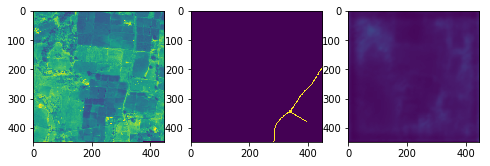

[-1,     2] loss: 2.453, accuracy: 0.025


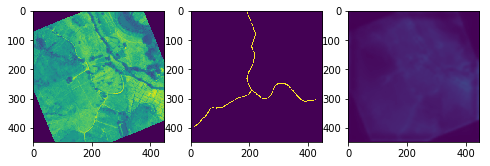

[-1,     3] loss: 2.575, accuracy: 0.037


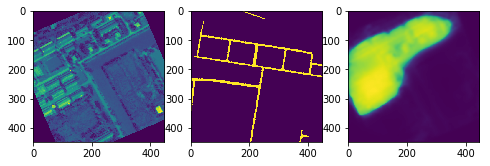

[-1,     4] loss: 2.240, accuracy: 0.074


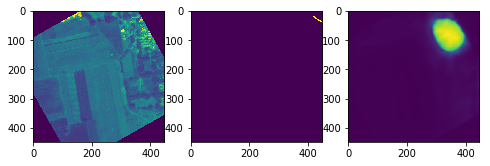

[-1,     5] loss: 2.388, accuracy: 0.076


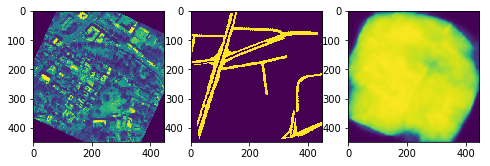

[-1,     6] loss: 2.531, accuracy: 0.046


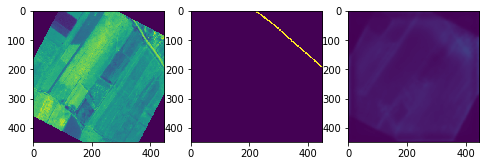

[-1,     7] loss: 2.433, accuracy: 0.029


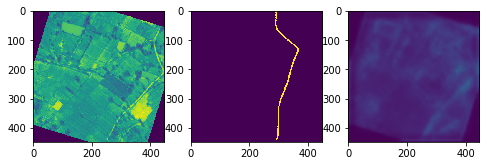

[-1,     8] loss: 2.487, accuracy: 0.044


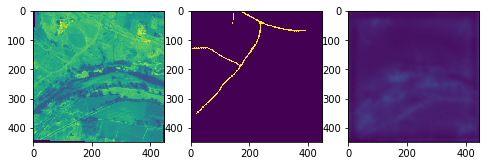

[-1,     9] loss: 2.061, accuracy: 0.056


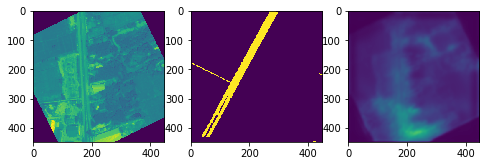

[-1,    10] loss: 2.232, accuracy: 0.058


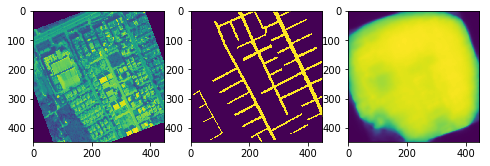

In [0]:
# Display validation results

import matplotlib.pyplot as plt
import numpy as np

# torch.save(model, 'classifier.pth')

# model = torch.load(model, 'classifier.pth')
# # checkpoint = torch.load('classifier.pth')
# # model.load_state_dict(checkpoint)




model = AlbuNet().to(device)
model.load_state_dict(torch.load('classifier.pth'))
model.eval()



print("Done loading.")

model.eval()


iters = 10

with torch.no_grad():
  for i, (image, mask) in enumerate(test_loader):
    
    if i >= iters:
      break
      
#     if (i+1) not in [3,5,8,9,10]:
#       continue
    
    inputs, mask = image.to(torch.cuda.current_device()), mask.to(torch.cuda.current_device())
    outputs = model(inputs)
    loss = criterion(outputs, mask)
    
#     print('[%d, %5d] loss: %.3f, accuracy: %.3f'  % (epoch + 1, i + 1, loss, soft_jaccard (outputs, mask)))
    print('[%d, %5d] loss: %.3f, accuracy: %.3f'  % (-1, i + 1, loss, soft_jaccard (outputs, mask)))

    
    cmap = "hot"
    cmap = "nipy_spectral"
    cmap = "viridis" # default
    
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    
    fig.add_subplot(rows, columns, 1)
    inputplot = plt.imshow(inputs.cpu()[0][0], cmap=cmap)
    fig.add_subplot(rows, columns, 2)
    maskplot = plt.imshow(mask.cpu()[0][0], cmap=cmap)
    fig.add_subplot(rows, columns, 3)
    outplot = plt.imshow(outputs.cpu()[0][0], cmap=cmap)
    
    
    plt.show()

      
 

# 25 epoch log

Started at: 2019-06-15 21:42:34.094135
[1,    10] loss: 1.747, accuracy: 0.027
[1,    20] loss: 1.553, accuracy: 0.031
[1,    30] loss: 1.360, accuracy: 0.049
[1,    40] loss: 1.318, accuracy: 0.046
[1,    50] loss: 1.140, accuracy: 0.034
[1,    60] loss: 1.232, accuracy: 0.043
[1,    70] loss: 1.138, accuracy: 0.033
[1,    80] loss: 1.187, accuracy: 0.035
[1,    90] loss: 1.073, accuracy: 0.074
[1,   100] loss: 1.132, accuracy: 0.024
[1,   110] loss: 1.148, accuracy: 0.044
[1,   120] loss: 1.243, accuracy: 0.026
[1,   130] loss: 1.235, accuracy: 0.089
[1,   140] loss: 1.016, accuracy: 0.050
[1,   150] loss: 1.150, accuracy: 0.050
[1,   160] loss: 1.298, accuracy: 0.045
[1,   170] loss: 1.245, accuracy: 0.046
[1,   180] loss: 1.071, accuracy: 0.046
[1,   190] loss: 1.174, accuracy: 0.040
[1,   200] loss: 1.096, accuracy: 0.033
[1,   210] loss: 1.024, accuracy: 0.039
[1,   220] loss: 1.105, accuracy: 0.056
[1,   230] loss: 1.035, accuracy: 0.063
[1,   240] loss: 1.004, accuracy: 0.066
[1,   250] loss: 1.021, accuracy: 0.058
[1,   260] loss: 1.139, accuracy: 0.027
[1,   270] loss: 1.170, accuracy: 0.036
[1,   280] loss: 1.085, accuracy: 0.065
[1,   290] loss: 1.097, accuracy: 0.030
[1,   300] loss: 1.000, accuracy: 0.038
[1,   310] loss: 1.143, accuracy: 0.024
[1,   320] loss: 1.160, accuracy: 0.074
[1,   330] loss: 1.087, accuracy: 0.024
[1,   340] loss: 1.178, accuracy: 0.028
[1,   350] loss: 1.101, accuracy: 0.042
[1,   360] loss: 1.038, accuracy: 0.030
[1,   370] loss: 1.124, accuracy: 0.046
[1,   380] loss: 1.078, accuracy: 0.024
[1,   390] loss: 1.199, accuracy: 0.027
[1,   400] loss: 1.109, accuracy: 0.033
[1,   410] loss: 1.032, accuracy: 0.038
[1,   420] loss: 1.003, accuracy: 0.039
[1,   430] loss: 1.166, accuracy: 0.041
[1,   440] loss: 1.097, accuracy: 0.045
[1,   450] loss: 1.057, accuracy: 0.062
[1,   460] loss: 1.079, accuracy: 0.064
[1,   470] loss: 1.204, accuracy: 0.035
[1,   480] loss: 1.184, accuracy: 0.020
[1,   490] loss: 1.061, accuracy: 0.042
[1,   500] loss: 0.985, accuracy: 0.046
[1,   510] loss: 1.036, accuracy: 0.039
[1,   520] loss: 1.016, accuracy: 0.048
[1,   530] loss: 0.990, accuracy: 0.040
[1,   540] loss: 0.969, accuracy: 0.042
[2,    10] loss: 1.139, accuracy: 0.031
[2,    20] loss: 1.072, accuracy: 0.028
[2,    30] loss: 1.097, accuracy: 0.054
[2,    40] loss: 1.191, accuracy: 0.048
[2,    50] loss: 1.058, accuracy: 0.036
[2,    60] loss: 1.052, accuracy: 0.048
[2,    70] loss: 1.001, accuracy: 0.035
[2,    80] loss: 1.091, accuracy: 0.037
[2,    90] loss: 1.047, accuracy: 0.072
[2,   100] loss: 1.085, accuracy: 0.022
[2,   110] loss: 1.105, accuracy: 0.046
[2,   120] loss: 1.064, accuracy: 0.029
[2,   130] loss: 1.165, accuracy: 0.092
[2,   140] loss: 0.980, accuracy: 0.052
[2,   150] loss: 1.082, accuracy: 0.051
[2,   160] loss: 1.230, accuracy: 0.041
[2,   170] loss: 1.198, accuracy: 0.045
[2,   180] loss: 1.037, accuracy: 0.047
[2,   190] loss: 1.095, accuracy: 0.038
[2,   200] loss: 1.062, accuracy: 0.032
[2,   210] loss: 1.030, accuracy: 0.038
[2,   220] loss: 1.062, accuracy: 0.055
[2,   230] loss: 0.998, accuracy: 0.068
[2,   240] loss: 0.945, accuracy: 0.068
[2,   250] loss: 0.986, accuracy: 0.061
[2,   260] loss: 1.121, accuracy: 0.026
[2,   270] loss: 1.113, accuracy: 0.035
[2,   280] loss: 1.060, accuracy: 0.061
[2,   290] loss: 1.087, accuracy: 0.029
[2,   300] loss: 1.001, accuracy: 0.040
[2,   310] loss: 1.077, accuracy: 0.025
[2,   320] loss: 1.131, accuracy: 0.078
[2,   330] loss: 1.063, accuracy: 0.021
[2,   340] loss: 1.106, accuracy: 0.031
[2,   350] loss: 1.042, accuracy: 0.042
[2,   360] loss: 1.039, accuracy: 0.030
[2,   370] loss: 1.082, accuracy: 0.049
[2,   380] loss: 1.112, accuracy: 0.026
[2,   390] loss: 1.171, accuracy: 0.026
[2,   400] loss: 1.036, accuracy: 0.035
[2,   410] loss: 0.949, accuracy: 0.038
[2,   420] loss: 1.004, accuracy: 0.042
[2,   430] loss: 1.156, accuracy: 0.041
[2,   440] loss: 1.091, accuracy: 0.047
[2,   450] loss: 1.029, accuracy: 0.060
[2,   460] loss: 1.018, accuracy: 0.060
[2,   470] loss: 1.158, accuracy: 0.031
[2,   480] loss: 1.147, accuracy: 0.020
[2,   490] loss: 0.999, accuracy: 0.042
[2,   500] loss: 1.010, accuracy: 0.048
[2,   510] loss: 1.034, accuracy: 0.040
[2,   520] loss: 1.031, accuracy: 0.050
[2,   530] loss: 0.939, accuracy: 0.039
[2,   540] loss: 0.991, accuracy: 0.045
[3,    10] loss: 1.153, accuracy: 0.029
[3,    20] loss: 1.085, accuracy: 0.029
[3,    30] loss: 1.061, accuracy: 0.056
[3,    40] loss: 1.128, accuracy: 0.046
[3,    50] loss: 1.003, accuracy: 0.037
[3,    60] loss: 1.054, accuracy: 0.049
[3,    70] loss: 1.007, accuracy: 0.033
[3,    80] loss: 1.133, accuracy: 0.038
[3,    90] loss: 1.057, accuracy: 0.070
[3,   100] loss: 1.034, accuracy: 0.021
[3,   110] loss: 1.069, accuracy: 0.046
[3,   120] loss: 1.165, accuracy: 0.025
[3,   130] loss: 1.170, accuracy: 0.087
[3,   140] loss: 0.975, accuracy: 0.053
[3,   150] loss: 1.053, accuracy: 0.046
[3,   160] loss: 1.243, accuracy: 0.045
[3,   170] loss: 1.164, accuracy: 0.043
[3,   180] loss: 1.014, accuracy: 0.045
[3,   190] loss: 1.117, accuracy: 0.038
[3,   200] loss: 1.075, accuracy: 0.033
[3,   210] loss: 1.027, accuracy: 0.038
[3,   220] loss: 1.033, accuracy: 0.053
[3,   230] loss: 1.007, accuracy: 0.069
[3,   240] loss: 0.958, accuracy: 0.065
[3,   250] loss: 1.009, accuracy: 0.058
[3,   260] loss: 1.092, accuracy: 0.023
[3,   270] loss: 1.093, accuracy: 0.034
[3,   280] loss: 1.037, accuracy: 0.070
[3,   290] loss: 1.076, accuracy: 0.030
[3,   300] loss: 1.002, accuracy: 0.039
[3,   310] loss: 1.097, accuracy: 0.024
[3,   320] loss: 1.076, accuracy: 0.080
[3,   330] loss: 1.073, accuracy: 0.021
[3,   340] loss: 1.115, accuracy: 0.031
[3,   350] loss: 1.038, accuracy: 0.045
[3,   360] loss: 1.038, accuracy: 0.029
[3,   370] loss: 1.073, accuracy: 0.049
[3,   380] loss: 1.107, accuracy: 0.025
[3,   390] loss: 1.171, accuracy: 0.025
[3,   400] loss: 1.064, accuracy: 0.032
[3,   410] loss: 0.957, accuracy: 0.040
[3,   420] loss: 0.965, accuracy: 0.041
[3,   430] loss: 1.146, accuracy: 0.042
[3,   440] loss: 1.043, accuracy: 0.049
[3,   450] loss: 1.042, accuracy: 0.063
[3,   460] loss: 1.061, accuracy: 0.065
[3,   470] loss: 1.145, accuracy: 0.031
[3,   480] loss: 1.177, accuracy: 0.024
[3,   490] loss: 1.046, accuracy: 0.041
[3,   500] loss: 1.023, accuracy: 0.045
[3,   510] loss: 0.992, accuracy: 0.042
[3,   520] loss: 1.025, accuracy: 0.051
[3,   530] loss: 0.961, accuracy: 0.039
[3,   540] loss: 0.974, accuracy: 0.042
[4,    10] loss: 1.181, accuracy: 0.029
[4,    20] loss: 1.069, accuracy: 0.027
[4,    30] loss: 1.052, accuracy: 0.050
[4,    40] loss: 1.084, accuracy: 0.045
[4,    50] loss: 1.024, accuracy: 0.035
[4,    60] loss: 1.042, accuracy: 0.052
[4,    70] loss: 1.036, accuracy: 0.032
[4,    80] loss: 1.022, accuracy: 0.038
[4,    90] loss: 1.019, accuracy: 0.072
[4,   100] loss: 1.030, accuracy: 0.026
[4,   110] loss: 1.055, accuracy: 0.038
[4,   120] loss: 1.122, accuracy: 0.027
[4,   130] loss: 1.188, accuracy: 0.086
[4,   140] loss: 0.975, accuracy: 0.057
[4,   150] loss: 1.050, accuracy: 0.054
[4,   160] loss: 1.246, accuracy: 0.044
[4,   170] loss: 1.187, accuracy: 0.044
[4,   180] loss: 1.032, accuracy: 0.048
[4,   190] loss: 1.095, accuracy: 0.036
[4,   200] loss: 1.056, accuracy: 0.034
[4,   210] loss: 1.012, accuracy: 0.036
[4,   220] loss: 1.025, accuracy: 0.058
[4,   230] loss: 1.010, accuracy: 0.066
[4,   240] loss: 0.940, accuracy: 0.062
[4,   250] loss: 0.919, accuracy: 0.059
[4,   260] loss: 1.106, accuracy: 0.024
[4,   270] loss: 1.123, accuracy: 0.033
[4,   280] loss: 1.043, accuracy: 0.069
[4,   290] loss: 1.126, accuracy: 0.027
[4,   300] loss: 1.010, accuracy: 0.039
[4,   310] loss: 1.066, accuracy: 0.025
[4,   320] loss: 1.121, accuracy: 0.076
[4,   330] loss: 1.051, accuracy: 0.021
[4,   340] loss: 1.116, accuracy: 0.029
[4,   350] loss: 1.049, accuracy: 0.046
[4,   360] loss: 1.016, accuracy: 0.031
[4,   370] loss: 1.098, accuracy: 0.045
[4,   380] loss: 1.111, accuracy: 0.023
[4,   390] loss: 1.156, accuracy: 0.024
[4,   400] loss: 1.042, accuracy: 0.035
[4,   410] loss: 0.973, accuracy: 0.041
[4,   420] loss: 0.971, accuracy: 0.041
[4,   430] loss: 1.137, accuracy: 0.042
[4,   440] loss: 1.050, accuracy: 0.051
[4,   450] loss: 1.017, accuracy: 0.062
[4,   460] loss: 1.058, accuracy: 0.058
[4,   470] loss: 1.126, accuracy: 0.033
[4,   480] loss: 1.177, accuracy: 0.024
[4,   490] loss: 1.024, accuracy: 0.042
[4,   500] loss: 0.986, accuracy: 0.045
[4,   510] loss: 1.020, accuracy: 0.039
[4,   520] loss: 0.993, accuracy: 0.055
[4,   530] loss: 0.955, accuracy: 0.040
[4,   540] loss: 1.001, accuracy: 0.047
[5,    10] loss: 1.164, accuracy: 0.028
[5,    20] loss: 1.091, accuracy: 0.027
[5,    30] loss: 1.084, accuracy: 0.054
[5,    40] loss: 1.122, accuracy: 0.046
[5,    50] loss: 0.990, accuracy: 0.035
[5,    60] loss: 1.066, accuracy: 0.050
[5,    70] loss: 1.013, accuracy: 0.033
[5,    80] loss: 1.096, accuracy: 0.036
[5,    90] loss: 1.012, accuracy: 0.069
[5,   100] loss: 1.037, accuracy: 0.025
[5,   110] loss: 1.055, accuracy: 0.040
[5,   120] loss: 1.086, accuracy: 0.027
[5,   130] loss: 1.165, accuracy: 0.085
[5,   140] loss: 0.977, accuracy: 0.054
[5,   150] loss: 1.053, accuracy: 0.051
[5,   160] loss: 1.166, accuracy: 0.047
[5,   170] loss: 1.182, accuracy: 0.044
[5,   180] loss: 0.997, accuracy: 0.046
[5,   190] loss: 1.054, accuracy: 0.038
[5,   200] loss: 1.032, accuracy: 0.036
[5,   210] loss: 0.997, accuracy: 0.041
[5,   220] loss: 0.993, accuracy: 0.057
[5,   230] loss: 0.996, accuracy: 0.067
[5,   240] loss: 0.939, accuracy: 0.064
[5,   250] loss: 0.986, accuracy: 0.058
[5,   260] loss: 1.069, accuracy: 0.027
[5,   270] loss: 1.116, accuracy: 0.034
[5,   280] loss: 1.052, accuracy: 0.068
[5,   290] loss: 1.053, accuracy: 0.030
[5,   300] loss: 0.996, accuracy: 0.044
[5,   310] loss: 1.090, accuracy: 0.028
[5,   320] loss: 1.055, accuracy: 0.079
[5,   330] loss: 1.048, accuracy: 0.020
[5,   340] loss: 1.016, accuracy: 0.030
[5,   350] loss: 1.047, accuracy: 0.048
[5,   360] loss: 1.036, accuracy: 0.030
[5,   370] loss: 1.042, accuracy: 0.044
[5,   380] loss: 1.106, accuracy: 0.025
[5,   390] loss: 1.149, accuracy: 0.026
[5,   400] loss: 1.041, accuracy: 0.034
[5,   410] loss: 0.985, accuracy: 0.037
[5,   420] loss: 0.997, accuracy: 0.037
[5,   430] loss: 1.114, accuracy: 0.040
[5,   440] loss: 1.045, accuracy: 0.050
[5,   450] loss: 1.031, accuracy: 0.059
[5,   460] loss: 0.990, accuracy: 0.064
[5,   470] loss: 1.100, accuracy: 0.035
[5,   480] loss: 1.103, accuracy: 0.023
[5,   490] loss: 0.984, accuracy: 0.043
[5,   500] loss: 1.018, accuracy: 0.046
[5,   510] loss: 1.021, accuracy: 0.042
[5,   520] loss: 1.010, accuracy: 0.050
[5,   530] loss: 0.969, accuracy: 0.037
[5,   540] loss: 1.009, accuracy: 0.043
[6,    10] loss: 1.110, accuracy: 0.030
[6,    20] loss: 1.066, accuracy: 0.029
[6,    30] loss: 1.065, accuracy: 0.056
[6,    40] loss: 1.151, accuracy: 0.046
[6,    50] loss: 1.034, accuracy: 0.034
[6,    60] loss: 1.071, accuracy: 0.049
[6,    70] loss: 0.986, accuracy: 0.035
[6,    80] loss: 1.085, accuracy: 0.038
[6,    90] loss: 1.025, accuracy: 0.070
[6,   100] loss: 1.035, accuracy: 0.024
[6,   110] loss: 1.071, accuracy: 0.044
[6,   120] loss: 1.133, accuracy: 0.025
[6,   130] loss: 1.179, accuracy: 0.080
[6,   140] loss: 0.998, accuracy: 0.051
[6,   150] loss: 1.051, accuracy: 0.050
[6,   160] loss: 1.138, accuracy: 0.042
[6,   170] loss: 1.123, accuracy: 0.043
[6,   180] loss: 1.030, accuracy: 0.046
[6,   190] loss: 1.084, accuracy: 0.037
[6,   200] loss: 1.019, accuracy: 0.034
[6,   210] loss: 1.005, accuracy: 0.039
[6,   220] loss: 1.014, accuracy: 0.055
[6,   230] loss: 0.960, accuracy: 0.063
[6,   240] loss: 0.923, accuracy: 0.068
[6,   250] loss: 0.963, accuracy: 0.061
[6,   260] loss: 1.096, accuracy: 0.021
[6,   270] loss: 1.093, accuracy: 0.033
[6,   280] loss: 1.059, accuracy: 0.067
[6,   290] loss: 1.009, accuracy: 0.031
[6,   300] loss: 0.992, accuracy: 0.037
[6,   310] loss: 1.094, accuracy: 0.026
[6,   320] loss: 1.050, accuracy: 0.082
[6,   330] loss: 1.029, accuracy: 0.021
[6,   340] loss: 1.088, accuracy: 0.032
[6,   350] loss: 1.019, accuracy: 0.043
[6,   360] loss: 1.025, accuracy: 0.030
[6,   370] loss: 1.063, accuracy: 0.046
[6,   380] loss: 1.131, accuracy: 0.024
[6,   390] loss: 1.091, accuracy: 0.025
[6,   400] loss: 1.006, accuracy: 0.036
[6,   410] loss: 0.930, accuracy: 0.041
[6,   420] loss: 0.973, accuracy: 0.043
[6,   430] loss: 1.119, accuracy: 0.041
[6,   440] loss: 0.991, accuracy: 0.051
[6,   450] loss: 1.030, accuracy: 0.061
[6,   460] loss: 1.038, accuracy: 0.065
[6,   470] loss: 1.067, accuracy: 0.031
[6,   480] loss: 1.191, accuracy: 0.024
[6,   490] loss: 1.054, accuracy: 0.040
[6,   500] loss: 0.997, accuracy: 0.047
[6,   510] loss: 1.028, accuracy: 0.038
[6,   520] loss: 1.024, accuracy: 0.051
[6,   530] loss: 0.959, accuracy: 0.038
[6,   540] loss: 0.976, accuracy: 0.044
[7,    10] loss: 1.149, accuracy: 0.030
[7,    20] loss: 1.051, accuracy: 0.031
[7,    30] loss: 1.065, accuracy: 0.050
[7,    40] loss: 1.086, accuracy: 0.043
[7,    50] loss: 1.001, accuracy: 0.036
[7,    60] loss: 1.087, accuracy: 0.049
[7,    70] loss: 1.042, accuracy: 0.032
[7,    80] loss: 1.050, accuracy: 0.036
[7,    90] loss: 1.030, accuracy: 0.072
[7,   100] loss: 1.033, accuracy: 0.019
[7,   110] loss: 1.089, accuracy: 0.049
[7,   120] loss: 1.040, accuracy: 0.029
[7,   130] loss: 1.137, accuracy: 0.085
[7,   140] loss: 0.921, accuracy: 0.053
[7,   150] loss: 1.045, accuracy: 0.053
[7,   160] loss: 1.182, accuracy: 0.050
[7,   170] loss: 1.192, accuracy: 0.041
[7,   180] loss: 0.986, accuracy: 0.046
[7,   190] loss: 1.103, accuracy: 0.038
[7,   200] loss: 1.035, accuracy: 0.035
[7,   210] loss: 0.989, accuracy: 0.042
[7,   220] loss: 1.022, accuracy: 0.061
[7,   230] loss: 0.948, accuracy: 0.070
[7,   240] loss: 0.935, accuracy: 0.063
[7,   250] loss: 0.966, accuracy: 0.060
[7,   260] loss: 1.074, accuracy: 0.024
[7,   270] loss: 1.058, accuracy: 0.035
[7,   280] loss: 1.059, accuracy: 0.067
[7,   290] loss: 1.074, accuracy: 0.031
[7,   300] loss: 0.965, accuracy: 0.043
[7,   310] loss: 1.087, accuracy: 0.024
[7,   320] loss: 1.037, accuracy: 0.085
[7,   330] loss: 1.033, accuracy: 0.021
[7,   340] loss: 1.088, accuracy: 0.032
[7,   350] loss: 1.024, accuracy: 0.044
[7,   360] loss: 1.037, accuracy: 0.030
[7,   370] loss: 1.046, accuracy: 0.049
[7,   380] loss: 1.117, accuracy: 0.022
[7,   390] loss: 1.133, accuracy: 0.025
[7,   400] loss: 1.038, accuracy: 0.033
[7,   410] loss: 0.934, accuracy: 0.036
[7,   420] loss: 0.985, accuracy: 0.040
[7,   430] loss: 1.075, accuracy: 0.042
[7,   440] loss: 1.003, accuracy: 0.050
[7,   450] loss: 0.992, accuracy: 0.060
[7,   460] loss: 1.009, accuracy: 0.064
[7,   470] loss: 1.128, accuracy: 0.030
[7,   480] loss: 1.094, accuracy: 0.022
[7,   490] loss: 1.001, accuracy: 0.041
[7,   500] loss: 0.992, accuracy: 0.044
[7,   510] loss: 0.984, accuracy: 0.038
[7,   520] loss: 0.978, accuracy: 0.055
[7,   530] loss: 0.933, accuracy: 0.040
[7,   540] loss: 0.978, accuracy: 0.045
[8,    10] loss: 1.125, accuracy: 0.029
[8,    20] loss: 1.009, accuracy: 0.026
[8,    30] loss: 1.094, accuracy: 0.052
[8,    40] loss: 1.104, accuracy: 0.045
[8,    50] loss: 0.978, accuracy: 0.035
[8,    60] loss: 0.994, accuracy: 0.047
[8,    70] loss: 0.960, accuracy: 0.032
[8,    80] loss: 1.070, accuracy: 0.036
[8,    90] loss: 1.024, accuracy: 0.074
[8,   100] loss: 1.056, accuracy: 0.024
[8,   110] loss: 1.025, accuracy: 0.047
[8,   120] loss: 1.052, accuracy: 0.028
[8,   130] loss: 1.122, accuracy: 0.092
[8,   140] loss: 0.942, accuracy: 0.058
[8,   150] loss: 1.014, accuracy: 0.049
[8,   160] loss: 1.208, accuracy: 0.045
[8,   170] loss: 1.146, accuracy: 0.045
[8,   180] loss: 0.981, accuracy: 0.043
[8,   190] loss: 1.085, accuracy: 0.043
[8,   200] loss: 1.074, accuracy: 0.032
[8,   210] loss: 0.991, accuracy: 0.035
[8,   220] loss: 1.014, accuracy: 0.062
[8,   230] loss: 1.003, accuracy: 0.069
[8,   240] loss: 0.906, accuracy: 0.066
[8,   250] loss: 0.985, accuracy: 0.060
[8,   260] loss: 1.086, accuracy: 0.022
[8,   270] loss: 1.054, accuracy: 0.035
[8,   280] loss: 1.021, accuracy: 0.067
[8,   290] loss: 1.102, accuracy: 0.030
[8,   300] loss: 0.915, accuracy: 0.041
[8,   310] loss: 1.070, accuracy: 0.023
[8,   320] loss: 1.046, accuracy: 0.084
[8,   330] loss: 1.028, accuracy: 0.021
[8,   340] loss: 1.097, accuracy: 0.032
[8,   350] loss: 1.011, accuracy: 0.045
[8,   360] loss: 1.013, accuracy: 0.029
[8,   370] loss: 1.055, accuracy: 0.046
[8,   380] loss: 1.070, accuracy: 0.022
[8,   390] loss: 1.124, accuracy: 0.025
[8,   400] loss: 1.062, accuracy: 0.030
[8,   410] loss: 0.984, accuracy: 0.042
[8,   420] loss: 0.972, accuracy: 0.043
[8,   430] loss: 1.142, accuracy: 0.038
[8,   440] loss: 1.062, accuracy: 0.045
[8,   450] loss: 1.004, accuracy: 0.060
[8,   460] loss: 1.012, accuracy: 0.060
[8,   470] loss: 1.086, accuracy: 0.035
[8,   480] loss: 1.079, accuracy: 0.021
[8,   490] loss: 1.001, accuracy: 0.043
[8,   500] loss: 1.025, accuracy: 0.047
[8,   510] loss: 0.999, accuracy: 0.043
[8,   520] loss: 0.962, accuracy: 0.050
[8,   530] loss: 0.953, accuracy: 0.039
[8,   540] loss: 0.953, accuracy: 0.044
[9,    10] loss: 1.125, accuracy: 0.029
[9,    20] loss: 1.030, accuracy: 0.026
[9,    30] loss: 1.038, accuracy: 0.054
[9,    40] loss: 1.096, accuracy: 0.044
[9,    50] loss: 0.982, accuracy: 0.035
[9,    60] loss: 1.028, accuracy: 0.046
[9,    70] loss: 0.986, accuracy: 0.033
[9,    80] loss: 1.052, accuracy: 0.033
[9,    90] loss: 1.003, accuracy: 0.071
[9,   100] loss: 1.040, accuracy: 0.025
[9,   110] loss: 1.055, accuracy: 0.048
[9,   120] loss: 1.040, accuracy: 0.028
[9,   130] loss: 1.157, accuracy: 0.084
[9,   140] loss: 0.931, accuracy: 0.051
[9,   150] loss: 1.013, accuracy: 0.055
[9,   160] loss: 1.172, accuracy: 0.045
[9,   170] loss: 1.094, accuracy: 0.042
[9,   180] loss: 0.965, accuracy: 0.046
[9,   190] loss: 1.083, accuracy: 0.040
[9,   200] loss: 1.034, accuracy: 0.035
[9,   210] loss: 0.988, accuracy: 0.036
[9,   220] loss: 0.997, accuracy: 0.059
[9,   230] loss: 0.937, accuracy: 0.072
[9,   240] loss: 0.912, accuracy: 0.063
[9,   250] loss: 0.964, accuracy: 0.059
[9,   260] loss: 1.068, accuracy: 0.022
[9,   270] loss: 1.060, accuracy: 0.038
[9,   280] loss: 1.017, accuracy: 0.065
[9,   290] loss: 1.041, accuracy: 0.030
[9,   300] loss: 0.954, accuracy: 0.039
[9,   310] loss: 1.067, accuracy: 0.027
[9,   320] loss: 1.050, accuracy: 0.081
[9,   330] loss: 0.984, accuracy: 0.021
[9,   340] loss: 1.067, accuracy: 0.030
[9,   350] loss: 1.009, accuracy: 0.044
[9,   360] loss: 1.051, accuracy: 0.031
[9,   370] loss: 1.037, accuracy: 0.046
[9,   380] loss: 1.038, accuracy: 0.023
[9,   390] loss: 1.095, accuracy: 0.026
[9,   400] loss: 1.011, accuracy: 0.035
[9,   410] loss: 0.995, accuracy: 0.037
[9,   420] loss: 0.963, accuracy: 0.041
[9,   430] loss: 1.103, accuracy: 0.041
[9,   440] loss: 1.064, accuracy: 0.050
[9,   450] loss: 1.036, accuracy: 0.062
[9,   460] loss: 0.990, accuracy: 0.062
[9,   470] loss: 1.109, accuracy: 0.028
[9,   480] loss: 1.133, accuracy: 0.022
[9,   490] loss: 0.995, accuracy: 0.043
[9,   500] loss: 0.962, accuracy: 0.049
[9,   510] loss: 0.992, accuracy: 0.043
[9,   520] loss: 1.014, accuracy: 0.051
[9,   530] loss: 0.956, accuracy: 0.040
[9,   540] loss: 0.986, accuracy: 0.045
[10,    10] loss: 1.111, accuracy: 0.032
[10,    20] loss: 1.069, accuracy: 0.030
[10,    30] loss: 1.020, accuracy: 0.053
[10,    40] loss: 1.112, accuracy: 0.047
[10,    50] loss: 0.953, accuracy: 0.035
[10,    60] loss: 1.053, accuracy: 0.048
[10,    70] loss: 0.981, accuracy: 0.032
[10,    80] loss: 1.044, accuracy: 0.038
[10,    90] loss: 1.009, accuracy: 0.070
[10,   100] loss: 1.045, accuracy: 0.022
[10,   110] loss: 1.053, accuracy: 0.049
[10,   120] loss: 1.104, accuracy: 0.027
[10,   130] loss: 1.138, accuracy: 0.084
[10,   140] loss: 0.945, accuracy: 0.052
[10,   150] loss: 1.059, accuracy: 0.052
[10,   160] loss: 1.196, accuracy: 0.045
[10,   170] loss: 1.192, accuracy: 0.043
[10,   180] loss: 0.965, accuracy: 0.045
[10,   190] loss: 1.033, accuracy: 0.041
[10,   200] loss: 1.048, accuracy: 0.034
[10,   210] loss: 0.992, accuracy: 0.038
[10,   220] loss: 1.016, accuracy: 0.059
[10,   230] loss: 0.974, accuracy: 0.069
[10,   240] loss: 0.919, accuracy: 0.065
[10,   250] loss: 0.956, accuracy: 0.061
[10,   260] loss: 1.095, accuracy: 0.025
[10,   270] loss: 1.036, accuracy: 0.034
[10,   280] loss: 1.030, accuracy: 0.064
[10,   290] loss: 1.099, accuracy: 0.029
[10,   300] loss: 0.960, accuracy: 0.040
[10,   310] loss: 1.065, accuracy: 0.025
[10,   320] loss: 1.054, accuracy: 0.073
[10,   330] loss: 0.990, accuracy: 0.024
[10,   340] loss: 1.047, accuracy: 0.031
[10,   350] loss: 1.046, accuracy: 0.048
[10,   360] loss: 1.018, accuracy: 0.032
[10,   370] loss: 1.023, accuracy: 0.042
[10,   380] loss: 1.077, accuracy: 0.023
[10,   390] loss: 1.020, accuracy: 0.028
[10,   400] loss: 1.065, accuracy: 0.035
[10,   410] loss: 0.950, accuracy: 0.037
[10,   420] loss: 0.947, accuracy: 0.044
[10,   430] loss: 1.093, accuracy: 0.039
[10,   440] loss: 1.020, accuracy: 0.049
[10,   450] loss: 1.000, accuracy: 0.064
[10,   460] loss: 0.982, accuracy: 0.063
[10,   470] loss: 1.049, accuracy: 0.031
[10,   480] loss: 1.127, accuracy: 0.025
[10,   490] loss: 0.990, accuracy: 0.041
[10,   500] loss: 0.978, accuracy: 0.048
[10,   510] loss: 0.978, accuracy: 0.040
[10,   520] loss: 1.008, accuracy: 0.049
[10,   530] loss: 0.967, accuracy: 0.042
[10,   540] loss: 0.964, accuracy: 0.043
[11,    10] loss: 1.129, accuracy: 0.029
[11,    20] loss: 1.075, accuracy: 0.028
[11,    30] loss: 1.054, accuracy: 0.055
[11,    40] loss: 1.081, accuracy: 0.046
[11,    50] loss: 0.993, accuracy: 0.036
[11,    60] loss: 1.028, accuracy: 0.049
[11,    70] loss: 0.992, accuracy: 0.034
[11,    80] loss: 1.074, accuracy: 0.038
[11,    90] loss: 1.017, accuracy: 0.070
[11,   100] loss: 1.025, accuracy: 0.024
[11,   110] loss: 1.053, accuracy: 0.045
[11,   120] loss: 1.027, accuracy: 0.029
[11,   130] loss: 1.161, accuracy: 0.087
[11,   140] loss: 0.937, accuracy: 0.051
[11,   150] loss: 1.017, accuracy: 0.056
[11,   160] loss: 1.150, accuracy: 0.044
[11,   170] loss: 1.097, accuracy: 0.044
[11,   180] loss: 0.982, accuracy: 0.047
[11,   190] loss: 1.090, accuracy: 0.037
[11,   200] loss: 1.056, accuracy: 0.032
[11,   210] loss: 0.981, accuracy: 0.038
[11,   220] loss: 1.010, accuracy: 0.060
[11,   230] loss: 0.930, accuracy: 0.068
[11,   240] loss: 0.870, accuracy: 0.065
[11,   250] loss: 0.961, accuracy: 0.063
[11,   260] loss: 1.033, accuracy: 0.022
[11,   270] loss: 1.140, accuracy: 0.033
[11,   280] loss: 1.056, accuracy: 0.064
[11,   290] loss: 1.074, accuracy: 0.031
[11,   300] loss: 0.973, accuracy: 0.042
[11,   310] loss: 1.058, accuracy: 0.026
[11,   320] loss: 1.042, accuracy: 0.073
[11,   330] loss: 1.017, accuracy: 0.021
[11,   340] loss: 1.055, accuracy: 0.032
[11,   350] loss: 1.039, accuracy: 0.044
[11,   360] loss: 1.025, accuracy: 0.028
[11,   370] loss: 1.058, accuracy: 0.044
[11,   380] loss: 1.085, accuracy: 0.023
[11,   390] loss: 1.194, accuracy: 0.022
[11,   400] loss: 1.048, accuracy: 0.035
[11,   410] loss: 0.967, accuracy: 0.037
[11,   420] loss: 0.977, accuracy: 0.041
[11,   430] loss: 1.121, accuracy: 0.038
[11,   440] loss: 1.021, accuracy: 0.050
[11,   450] loss: 1.012, accuracy: 0.061
[11,   460] loss: 0.992, accuracy: 0.062
[11,   470] loss: 1.061, accuracy: 0.031
[11,   480] loss: 1.059, accuracy: 0.025
[11,   490] loss: 0.992, accuracy: 0.045
[11,   500] loss: 0.952, accuracy: 0.050
[11,   510] loss: 1.009, accuracy: 0.042
[11,   520] loss: 0.986, accuracy: 0.050
[11,   530] loss: 0.952, accuracy: 0.039
[11,   540] loss: 0.954, accuracy: 0.045
[12,    10] loss: 1.115, accuracy: 0.030
[12,    20] loss: 1.051, accuracy: 0.032
[12,    30] loss: 1.025, accuracy: 0.048
[12,    40] loss: 1.070, accuracy: 0.049
[12,    50] loss: 0.986, accuracy: 0.037
[12,    60] loss: 1.027, accuracy: 0.049
[12,    70] loss: 0.956, accuracy: 0.033
[12,    80] loss: 1.074, accuracy: 0.037
[12,    90] loss: 1.024, accuracy: 0.075
[12,   100] loss: 0.996, accuracy: 0.024
[12,   110] loss: 1.012, accuracy: 0.047
[12,   120] loss: 1.065, accuracy: 0.029
[12,   130] loss: 1.154, accuracy: 0.086
[12,   140] loss: 1.022, accuracy: 0.052
[12,   150] loss: 1.085, accuracy: 0.049
[12,   160] loss: 1.155, accuracy: 0.046
[12,   170] loss: 1.109, accuracy: 0.044
[12,   180] loss: 1.000, accuracy: 0.049
[12,   190] loss: 1.090, accuracy: 0.040
[12,   200] loss: 1.063, accuracy: 0.032
[12,   210] loss: 0.966, accuracy: 0.038
[12,   220] loss: 0.979, accuracy: 0.058
[12,   230] loss: 0.961, accuracy: 0.067
[12,   240] loss: 0.909, accuracy: 0.064
[12,   250] loss: 0.936, accuracy: 0.056
[12,   260] loss: 1.060, accuracy: 0.023
[12,   270] loss: 1.093, accuracy: 0.034
[12,   280] loss: 0.978, accuracy: 0.069
[12,   290] loss: 1.060, accuracy: 0.024
[12,   300] loss: 0.948, accuracy: 0.042
[12,   310] loss: 1.063, accuracy: 0.025
[12,   320] loss: 1.059, accuracy: 0.078
[12,   330] loss: 1.015, accuracy: 0.020
[12,   340] loss: 1.036, accuracy: 0.030
[12,   350] loss: 1.017, accuracy: 0.044
[12,   360] loss: 0.997, accuracy: 0.031
[12,   370] loss: 1.059, accuracy: 0.046
[12,   380] loss: 1.038, accuracy: 0.024
[12,   390] loss: 1.084, accuracy: 0.023
[12,   400] loss: 0.995, accuracy: 0.035
[12,   410] loss: 0.942, accuracy: 0.039
[12,   420] loss: 0.931, accuracy: 0.044
[12,   430] loss: 1.084, accuracy: 0.042
[12,   440] loss: 1.056, accuracy: 0.047
[12,   450] loss: 1.019, accuracy: 0.063
[12,   460] loss: 0.997, accuracy: 0.062
[12,   470] loss: 1.054, accuracy: 0.030
[12,   480] loss: 1.083, accuracy: 0.026
[12,   490] loss: 0.996, accuracy: 0.041
[12,   500] loss: 0.966, accuracy: 0.045
[12,   510] loss: 0.981, accuracy: 0.042
[12,   520] loss: 0.965, accuracy: 0.050
[12,   530] loss: 0.946, accuracy: 0.041
[12,   540] loss: 0.945, accuracy: 0.044
[13,    10] loss: 1.211, accuracy: 0.030
[13,    20] loss: 1.067, accuracy: 0.030
[13,    30] loss: 1.093, accuracy: 0.051
[13,    40] loss: 1.111, accuracy: 0.046
[13,    50] loss: 0.978, accuracy: 0.037
[13,    60] loss: 1.040, accuracy: 0.048
[13,    70] loss: 0.963, accuracy: 0.036
[13,    80] loss: 1.084, accuracy: 0.039
[13,    90] loss: 1.024, accuracy: 0.072
[13,   100] loss: 1.037, accuracy: 0.023
[13,   110] loss: 1.024, accuracy: 0.045
[13,   120] loss: 1.045, accuracy: 0.026
[13,   130] loss: 1.106, accuracy: 0.088
[13,   140] loss: 0.982, accuracy: 0.055
[13,   150] loss: 1.028, accuracy: 0.054
[13,   160] loss: 1.159, accuracy: 0.046
[13,   170] loss: 1.111, accuracy: 0.042
[13,   180] loss: 1.051, accuracy: 0.044
[13,   190] loss: 1.132, accuracy: 0.041
[13,   200] loss: 1.050, accuracy: 0.032
[13,   210] loss: 0.982, accuracy: 0.037
[13,   220] loss: 0.970, accuracy: 0.058
[13,   230] loss: 0.966, accuracy: 0.069
[13,   240] loss: 0.916, accuracy: 0.064
[13,   250] loss: 0.954, accuracy: 0.060
[13,   260] loss: 1.093, accuracy: 0.021
[13,   270] loss: 1.047, accuracy: 0.033
[13,   280] loss: 0.998, accuracy: 0.067
[13,   290] loss: 1.060, accuracy: 0.032
[13,   300] loss: 0.945, accuracy: 0.039
[13,   310] loss: 1.027, accuracy: 0.027
[13,   320] loss: 1.018, accuracy: 0.077
[13,   330] loss: 1.020, accuracy: 0.021
[13,   340] loss: 1.052, accuracy: 0.032
[13,   350] loss: 1.043, accuracy: 0.044
[13,   360] loss: 1.021, accuracy: 0.029
[13,   370] loss: 1.025, accuracy: 0.047
[13,   380] loss: 1.062, accuracy: 0.027
[13,   390] loss: 1.057, accuracy: 0.025
[13,   400] loss: 1.006, accuracy: 0.034
[13,   410] loss: 0.922, accuracy: 0.038
[13,   420] loss: 0.960, accuracy: 0.039
[13,   430] loss: 1.091, accuracy: 0.040
[13,   440] loss: 1.010, accuracy: 0.052
[13,   450] loss: 1.031, accuracy: 0.063
[13,   460] loss: 0.980, accuracy: 0.062
[13,   470] loss: 1.037, accuracy: 0.030
[13,   480] loss: 1.091, accuracy: 0.025
[13,   490] loss: 0.960, accuracy: 0.041
[13,   500] loss: 0.975, accuracy: 0.046
[13,   510] loss: 0.997, accuracy: 0.042
[13,   520] loss: 0.973, accuracy: 0.053
[13,   530] loss: 0.913, accuracy: 0.038
[13,   540] loss: 0.972, accuracy: 0.044
[14,    10] loss: 1.096, accuracy: 0.030
[14,    20] loss: 1.038, accuracy: 0.030
[14,    30] loss: 1.063, accuracy: 0.051
[14,    40] loss: 1.102, accuracy: 0.047
[14,    50] loss: 0.979, accuracy: 0.037
[14,    60] loss: 1.077, accuracy: 0.047
[14,    70] loss: 0.962, accuracy: 0.035
[14,    80] loss: 1.144, accuracy: 0.037
[14,    90] loss: 1.028, accuracy: 0.071
[14,   100] loss: 1.035, accuracy: 0.025
[14,   110] loss: 1.027, accuracy: 0.047
[14,   120] loss: 1.046, accuracy: 0.030
[14,   130] loss: 1.145, accuracy: 0.079
[14,   140] loss: 0.955, accuracy: 0.054
[14,   150] loss: 1.048, accuracy: 0.052
[14,   160] loss: 1.171, accuracy: 0.047
[14,   170] loss: 1.106, accuracy: 0.044
[14,   180] loss: 0.991, accuracy: 0.045
[14,   190] loss: 1.118, accuracy: 0.036
[14,   200] loss: 1.044, accuracy: 0.035
[14,   210] loss: 0.978, accuracy: 0.034
[14,   220] loss: 1.052, accuracy: 0.059
[14,   230] loss: 0.952, accuracy: 0.071
[14,   240] loss: 0.906, accuracy: 0.068
[14,   250] loss: 0.977, accuracy: 0.057
[14,   260] loss: 1.108, accuracy: 0.025
[14,   270] loss: 1.073, accuracy: 0.036
[14,   280] loss: 1.053, accuracy: 0.068
[14,   290] loss: 1.070, accuracy: 0.028
[14,   300] loss: 0.964, accuracy: 0.038
[14,   310] loss: 1.040, accuracy: 0.026
[14,   320] loss: 1.042, accuracy: 0.078
[14,   330] loss: 1.022, accuracy: 0.019
[14,   340] loss: 1.065, accuracy: 0.031
[14,   350] loss: 1.010, accuracy: 0.045
[14,   360] loss: 1.015, accuracy: 0.031
[14,   370] loss: 1.008, accuracy: 0.050
[14,   380] loss: 1.070, accuracy: 0.025
[14,   390] loss: 1.129, accuracy: 0.024
[14,   400] loss: 1.030, accuracy: 0.032
[14,   410] loss: 0.947, accuracy: 0.037
[14,   420] loss: 0.952, accuracy: 0.041
[14,   430] loss: 1.071, accuracy: 0.043
[14,   440] loss: 0.978, accuracy: 0.048
[14,   450] loss: 1.006, accuracy: 0.062
[14,   460] loss: 0.989, accuracy: 0.060
[14,   470] loss: 1.059, accuracy: 0.034
[14,   480] loss: 1.111, accuracy: 0.023
[14,   490] loss: 1.000, accuracy: 0.043
[14,   500] loss: 0.995, accuracy: 0.048
[14,   510] loss: 0.986, accuracy: 0.039
[14,   520] loss: 1.002, accuracy: 0.052
[14,   530] loss: 0.946, accuracy: 0.039
[14,   540] loss: 0.973, accuracy: 0.043
[15,    10] loss: 1.129, accuracy: 0.030
[15,    20] loss: 1.002, accuracy: 0.032
[15,    30] loss: 1.023, accuracy: 0.050
[15,    40] loss: 1.121, accuracy: 0.048
[15,    50] loss: 0.995, accuracy: 0.036
[15,    60] loss: 1.039, accuracy: 0.046
[15,    70] loss: 0.969, accuracy: 0.033
[15,    80] loss: 1.067, accuracy: 0.037
[15,    90] loss: 1.018, accuracy: 0.076
[15,   100] loss: 1.051, accuracy: 0.020
[15,   110] loss: 0.994, accuracy: 0.049
[15,   120] loss: 1.068, accuracy: 0.030
[15,   130] loss: 1.189, accuracy: 0.092
[15,   140] loss: 0.932, accuracy: 0.054
[15,   150] loss: 1.013, accuracy: 0.052
[15,   160] loss: 1.124, accuracy: 0.044
[15,   170] loss: 1.089, accuracy: 0.044
[15,   180] loss: 1.046, accuracy: 0.046
[15,   190] loss: 1.079, accuracy: 0.040
[15,   200] loss: 1.067, accuracy: 0.031
[15,   210] loss: 0.972, accuracy: 0.036
[15,   220] loss: 0.974, accuracy: 0.056
[15,   230] loss: 0.949, accuracy: 0.072
[15,   240] loss: 0.899, accuracy: 0.064
[15,   250] loss: 0.932, accuracy: 0.065
[15,   260] loss: 1.072, accuracy: 0.024
[15,   270] loss: 0.992, accuracy: 0.036
[15,   280] loss: 1.008, accuracy: 0.067
[15,   290] loss: 1.074, accuracy: 0.030
[15,   300] loss: 0.951, accuracy: 0.039
[15,   310] loss: 1.043, accuracy: 0.026
[15,   320] loss: 1.039, accuracy: 0.080
[15,   330] loss: 0.971, accuracy: 0.022
[15,   340] loss: 1.053, accuracy: 0.028
[15,   350] loss: 1.034, accuracy: 0.044
[15,   360] loss: 1.016, accuracy: 0.031
[15,   370] loss: 1.081, accuracy: 0.043
[15,   380] loss: 1.070, accuracy: 0.024
[15,   390] loss: 1.103, accuracy: 0.025
[15,   400] loss: 1.041, accuracy: 0.028
[15,   410] loss: 0.973, accuracy: 0.036
[15,   420] loss: 0.970, accuracy: 0.045
[15,   430] loss: 1.124, accuracy: 0.039
[15,   440] loss: 0.992, accuracy: 0.048
[15,   450] loss: 1.024, accuracy: 0.063
[15,   460] loss: 0.990, accuracy: 0.065
[15,   470] loss: 1.088, accuracy: 0.032
[15,   480] loss: 1.093, accuracy: 0.023
[15,   490] loss: 0.972, accuracy: 0.042
[15,   500] loss: 1.006, accuracy: 0.049
[15,   510] loss: 1.006, accuracy: 0.039
[15,   520] loss: 1.003, accuracy: 0.053
[15,   530] loss: 0.970, accuracy: 0.037
[15,   540] loss: 0.950, accuracy: 0.042
[16,    10] loss: 1.116, accuracy: 0.030
[16,    20] loss: 1.033, accuracy: 0.027
[16,    30] loss: 1.042, accuracy: 0.056
[16,    40] loss: 1.083, accuracy: 0.047
[16,    50] loss: 0.987, accuracy: 0.035
[16,    60] loss: 1.020, accuracy: 0.048
[16,    70] loss: 0.973, accuracy: 0.032
[16,    80] loss: 1.032, accuracy: 0.038
[16,    90] loss: 1.037, accuracy: 0.071
[16,   100] loss: 1.034, accuracy: 0.021
[16,   110] loss: 1.053, accuracy: 0.047
[16,   120] loss: 1.011, accuracy: 0.029
[16,   130] loss: 1.177, accuracy: 0.092
[16,   140] loss: 0.984, accuracy: 0.054
[16,   150] loss: 1.012, accuracy: 0.057
[16,   160] loss: 1.122, accuracy: 0.043
[16,   170] loss: 1.125, accuracy: 0.043
[16,   180] loss: 1.058, accuracy: 0.046
[16,   190] loss: 1.093, accuracy: 0.044
[16,   200] loss: 1.029, accuracy: 0.032
[16,   210] loss: 0.978, accuracy: 0.041
[16,   220] loss: 0.995, accuracy: 0.057
[16,   230] loss: 0.922, accuracy: 0.069
[16,   240] loss: 0.914, accuracy: 0.064
[16,   250] loss: 0.928, accuracy: 0.061
[16,   260] loss: 1.058, accuracy: 0.025
[16,   270] loss: 1.071, accuracy: 0.035
[16,   280] loss: 1.049, accuracy: 0.069
[16,   290] loss: 1.091, accuracy: 0.030
[16,   300] loss: 0.953, accuracy: 0.040
[16,   310] loss: 1.002, accuracy: 0.026
[16,   320] loss: 1.043, accuracy: 0.078
[16,   330] loss: 0.999, accuracy: 0.024
[16,   340] loss: 1.056, accuracy: 0.032
[16,   350] loss: 1.040, accuracy: 0.046
[16,   360] loss: 1.005, accuracy: 0.029
[16,   370] loss: 1.043, accuracy: 0.045
[16,   380] loss: 1.083, accuracy: 0.021
[16,   390] loss: 1.108, accuracy: 0.026
[16,   400] loss: 1.025, accuracy: 0.033
[16,   410] loss: 0.938, accuracy: 0.037
[16,   420] loss: 0.975, accuracy: 0.044
[16,   430] loss: 1.043, accuracy: 0.042
[16,   440] loss: 0.973, accuracy: 0.048
[16,   450] loss: 0.996, accuracy: 0.059
[16,   460] loss: 0.944, accuracy: 0.063
[16,   470] loss: 1.037, accuracy: 0.030
[16,   480] loss: 1.075, accuracy: 0.027
[16,   490] loss: 0.967, accuracy: 0.044
[16,   500] loss: 0.973, accuracy: 0.043
[16,   510] loss: 0.953, accuracy: 0.039
[16,   520] loss: 0.968, accuracy: 0.049
[16,   530] loss: 0.923, accuracy: 0.038
[16,   540] loss: 0.982, accuracy: 0.041
[17,    10] loss: 1.100, accuracy: 0.032
[17,    20] loss: 1.021, accuracy: 0.028
[17,    30] loss: 1.036, accuracy: 0.052
[17,    40] loss: 1.113, accuracy: 0.047
[17,    50] loss: 0.985, accuracy: 0.037
[17,    60] loss: 1.021, accuracy: 0.050
[17,    70] loss: 0.963, accuracy: 0.035
[17,    80] loss: 1.034, accuracy: 0.036
[17,    90] loss: 1.007, accuracy: 0.072
[17,   100] loss: 1.038, accuracy: 0.021
[17,   110] loss: 1.056, accuracy: 0.048
[17,   120] loss: 1.064, accuracy: 0.026
[17,   130] loss: 1.127, accuracy: 0.095
[17,   140] loss: 0.908, accuracy: 0.055
[17,   150] loss: 0.992, accuracy: 0.051
[17,   160] loss: 1.168, accuracy: 0.048
[17,   170] loss: 1.139, accuracy: 0.045
[17,   180] loss: 0.960, accuracy: 0.047
[17,   190] loss: 1.090, accuracy: 0.041
[17,   200] loss: 1.034, accuracy: 0.035
[17,   210] loss: 0.945, accuracy: 0.039
[17,   220] loss: 1.013, accuracy: 0.058
[17,   230] loss: 0.938, accuracy: 0.068
[17,   240] loss: 0.908, accuracy: 0.066
[17,   250] loss: 0.935, accuracy: 0.057
[17,   260] loss: 1.090, accuracy: 0.023
[17,   270] loss: 1.050, accuracy: 0.033
[17,   280] loss: 1.052, accuracy: 0.065
[17,   290] loss: 1.103, accuracy: 0.031
[17,   300] loss: 0.934, accuracy: 0.038
[17,   310] loss: 1.060, accuracy: 0.025
[17,   320] loss: 1.011, accuracy: 0.080
[17,   330] loss: 1.030, accuracy: 0.021
[17,   340] loss: 1.056, accuracy: 0.029
[17,   350] loss: 1.036, accuracy: 0.040
[17,   360] loss: 1.023, accuracy: 0.029
[17,   370] loss: 1.060, accuracy: 0.045
[17,   380] loss: 1.069, accuracy: 0.025
[17,   390] loss: 1.135, accuracy: 0.024
[17,   400] loss: 1.010, accuracy: 0.035
[17,   410] loss: 0.936, accuracy: 0.041
[17,   420] loss: 0.962, accuracy: 0.040
[17,   430] loss: 1.094, accuracy: 0.040
[17,   440] loss: 0.995, accuracy: 0.050
[17,   450] loss: 0.984, accuracy: 0.062
[17,   460] loss: 0.970, accuracy: 0.060
[17,   470] loss: 1.047, accuracy: 0.033
[17,   480] loss: 1.087, accuracy: 0.024
[17,   490] loss: 0.978, accuracy: 0.044
[17,   500] loss: 0.988, accuracy: 0.051
[17,   510] loss: 1.001, accuracy: 0.035
[17,   520] loss: 0.942, accuracy: 0.054
[17,   530] loss: 0.941, accuracy: 0.038
[17,   540] loss: 0.964, accuracy: 0.045
[18,    10] loss: 1.119, accuracy: 0.030
[18,    20] loss: 1.021, accuracy: 0.029
[18,    30] loss: 1.020, accuracy: 0.053
[18,    40] loss: 1.095, accuracy: 0.048
[18,    50] loss: 0.987, accuracy: 0.036
[18,    60] loss: 1.027, accuracy: 0.049
[18,    70] loss: 0.968, accuracy: 0.032
[18,    80] loss: 1.070, accuracy: 0.036
[18,    90] loss: 0.985, accuracy: 0.071
[18,   100] loss: 1.044, accuracy: 0.020
[18,   110] loss: 1.063, accuracy: 0.039
[18,   120] loss: 1.092, accuracy: 0.030
[18,   130] loss: 1.181, accuracy: 0.090
[18,   140] loss: 0.947, accuracy: 0.051
[18,   150] loss: 1.028, accuracy: 0.051
[18,   160] loss: 1.147, accuracy: 0.044
[18,   170] loss: 1.120, accuracy: 0.045
[18,   180] loss: 0.977, accuracy: 0.048
[18,   190] loss: 1.063, accuracy: 0.037
[18,   200] loss: 1.051, accuracy: 0.033
[18,   210] loss: 0.955, accuracy: 0.036
[18,   220] loss: 1.005, accuracy: 0.057
[18,   230] loss: 0.951, accuracy: 0.066
[18,   240] loss: 0.922, accuracy: 0.064
[18,   250] loss: 0.930, accuracy: 0.060
[18,   260] loss: 1.055, accuracy: 0.025
[18,   270] loss: 1.080, accuracy: 0.033
[18,   280] loss: 1.012, accuracy: 0.071
[18,   290] loss: 1.037, accuracy: 0.029
[18,   300] loss: 0.943, accuracy: 0.037
[18,   310] loss: 1.041, accuracy: 0.026
[18,   320] loss: 1.071, accuracy: 0.078
[18,   330] loss: 1.015, accuracy: 0.022
[18,   340] loss: 1.075, accuracy: 0.033
[18,   350] loss: 0.977, accuracy: 0.045
[18,   360] loss: 1.007, accuracy: 0.032
[18,   370] loss: 1.011, accuracy: 0.045
[18,   380] loss: 1.069, accuracy: 0.025
[18,   390] loss: 1.163, accuracy: 0.024
[18,   400] loss: 0.993, accuracy: 0.033
[18,   410] loss: 0.930, accuracy: 0.038
[18,   420] loss: 0.953, accuracy: 0.039
[18,   430] loss: 1.081, accuracy: 0.042
[18,   440] loss: 0.981, accuracy: 0.050
[18,   450] loss: 0.998, accuracy: 0.059
[18,   460] loss: 0.959, accuracy: 0.061
[18,   470] loss: 1.084, accuracy: 0.035
[18,   480] loss: 1.071, accuracy: 0.027
[18,   490] loss: 1.003, accuracy: 0.042
[18,   500] loss: 0.992, accuracy: 0.048
[18,   510] loss: 0.964, accuracy: 0.041
[18,   520] loss: 1.006, accuracy: 0.049
[18,   530] loss: 0.941, accuracy: 0.040
[18,   540] loss: 0.976, accuracy: 0.042
[19,    10] loss: 1.102, accuracy: 0.032
[19,    20] loss: 1.013, accuracy: 0.029
[19,    30] loss: 1.046, accuracy: 0.054
[19,    40] loss: 1.094, accuracy: 0.047
[19,    50] loss: 0.965, accuracy: 0.038
[19,    60] loss: 1.023, accuracy: 0.050
[19,    70] loss: 0.994, accuracy: 0.030
[19,    80] loss: 1.066, accuracy: 0.037
[19,    90] loss: 1.026, accuracy: 0.074
[19,   100] loss: 1.026, accuracy: 0.022
[19,   110] loss: 0.985, accuracy: 0.046
[19,   120] loss: 1.070, accuracy: 0.027
[19,   130] loss: 1.149, accuracy: 0.083
[19,   140] loss: 0.919, accuracy: 0.053
[19,   150] loss: 1.002, accuracy: 0.051
[19,   160] loss: 1.148, accuracy: 0.043
[19,   170] loss: 1.137, accuracy: 0.044
[19,   180] loss: 0.989, accuracy: 0.041
[19,   190] loss: 1.074, accuracy: 0.040
[19,   200] loss: 1.045, accuracy: 0.035
[19,   210] loss: 0.967, accuracy: 0.040
[19,   220] loss: 1.016, accuracy: 0.056
[19,   230] loss: 0.958, accuracy: 0.071
[19,   240] loss: 0.909, accuracy: 0.066
[19,   250] loss: 0.934, accuracy: 0.062
[19,   260] loss: 1.053, accuracy: 0.023
[19,   270] loss: 1.047, accuracy: 0.037
[19,   280] loss: 1.022, accuracy: 0.069
[19,   290] loss: 1.055, accuracy: 0.032
[19,   300] loss: 0.923, accuracy: 0.040
[19,   310] loss: 1.014, accuracy: 0.024
[19,   320] loss: 1.028, accuracy: 0.082
[19,   330] loss: 1.005, accuracy: 0.022
[19,   340] loss: 1.037, accuracy: 0.030
[19,   350] loss: 1.017, accuracy: 0.042
[19,   360] loss: 1.022, accuracy: 0.032
[19,   370] loss: 1.018, accuracy: 0.048
[19,   380] loss: 1.067, accuracy: 0.023
[19,   390] loss: 1.046, accuracy: 0.027
[19,   400] loss: 0.982, accuracy: 0.034
[19,   410] loss: 0.894, accuracy: 0.038
[19,   420] loss: 0.977, accuracy: 0.042
[19,   430] loss: 1.082, accuracy: 0.039
[19,   440] loss: 0.995, accuracy: 0.054
[19,   450] loss: 1.017, accuracy: 0.060
[19,   460] loss: 0.944, accuracy: 0.063
[19,   470] loss: 1.073, accuracy: 0.033
[19,   480] loss: 1.060, accuracy: 0.026
[19,   490] loss: 0.966, accuracy: 0.043
[19,   500] loss: 0.980, accuracy: 0.051
[19,   510] loss: 0.964, accuracy: 0.042
[19,   520] loss: 0.971, accuracy: 0.054
[19,   530] loss: 0.936, accuracy: 0.037
[19,   540] loss: 0.961, accuracy: 0.043
[20,    10] loss: 1.111, accuracy: 0.028
[20,    20] loss: 1.036, accuracy: 0.029
[20,    30] loss: 1.027, accuracy: 0.057
[20,    40] loss: 1.065, accuracy: 0.045
[20,    50] loss: 0.968, accuracy: 0.036
[20,    60] loss: 0.991, accuracy: 0.052
[20,    70] loss: 0.967, accuracy: 0.034
[20,    80] loss: 1.041, accuracy: 0.035
[20,    90] loss: 0.996, accuracy: 0.072
[20,   100] loss: 1.008, accuracy: 0.024
[20,   110] loss: 1.023, accuracy: 0.048
[20,   120] loss: 1.011, accuracy: 0.028
[20,   130] loss: 1.094, accuracy: 0.097
[20,   140] loss: 0.956, accuracy: 0.051
[20,   150] loss: 1.037, accuracy: 0.053
[20,   160] loss: 1.201, accuracy: 0.045
[20,   170] loss: 1.114, accuracy: 0.041
[20,   180] loss: 0.995, accuracy: 0.044
[20,   190] loss: 1.034, accuracy: 0.036
[20,   200] loss: 1.044, accuracy: 0.034
[20,   210] loss: 0.993, accuracy: 0.039
[20,   220] loss: 1.016, accuracy: 0.057
[20,   230] loss: 0.965, accuracy: 0.066
[20,   240] loss: 0.905, accuracy: 0.065
[20,   250] loss: 0.977, accuracy: 0.058
[20,   260] loss: 1.057, accuracy: 0.023
[20,   270] loss: 1.040, accuracy: 0.034
[20,   280] loss: 1.022, accuracy: 0.068
[20,   290] loss: 1.072, accuracy: 0.029
[20,   300] loss: 0.970, accuracy: 0.042
[20,   310] loss: 1.042, accuracy: 0.027
[20,   320] loss: 1.010, accuracy: 0.073
[20,   330] loss: 0.958, accuracy: 0.023
[20,   340] loss: 1.042, accuracy: 0.029
[20,   350] loss: 0.990, accuracy: 0.042
[20,   360] loss: 1.018, accuracy: 0.031
[20,   370] loss: 1.041, accuracy: 0.045
[20,   380] loss: 1.052, accuracy: 0.027
[20,   390] loss: 1.089, accuracy: 0.027
[20,   400] loss: 0.976, accuracy: 0.034
[20,   410] loss: 0.945, accuracy: 0.040
[20,   420] loss: 0.964, accuracy: 0.040
[20,   430] loss: 1.097, accuracy: 0.041
[20,   440] loss: 1.028, accuracy: 0.054
[20,   450] loss: 1.009, accuracy: 0.065
[20,   460] loss: 0.958, accuracy: 0.063
[20,   470] loss: 1.038, accuracy: 0.031
[20,   480] loss: 1.058, accuracy: 0.025
[20,   490] loss: 0.977, accuracy: 0.042
[20,   500] loss: 0.965, accuracy: 0.047
[20,   510] loss: 0.936, accuracy: 0.044
[20,   520] loss: 0.949, accuracy: 0.051
[20,   530] loss: 0.951, accuracy: 0.038
[20,   540] loss: 0.957, accuracy: 0.042
[21,    10] loss: 1.124, accuracy: 0.030
[21,    20] loss: 1.000, accuracy: 0.029
[21,    30] loss: 1.012, accuracy: 0.054
[21,    40] loss: 1.111, accuracy: 0.050
[21,    50] loss: 0.938, accuracy: 0.038
[21,    60] loss: 0.995, accuracy: 0.051
[21,    70] loss: 0.968, accuracy: 0.035
[21,    80] loss: 1.048, accuracy: 0.037
[21,    90] loss: 1.001, accuracy: 0.071
[21,   100] loss: 1.000, accuracy: 0.024
[21,   110] loss: 1.021, accuracy: 0.038
[21,   120] loss: 1.072, accuracy: 0.028
[21,   130] loss: 1.112, accuracy: 0.098
[21,   140] loss: 0.915, accuracy: 0.054
[21,   150] loss: 1.004, accuracy: 0.047
[21,   160] loss: 1.180, accuracy: 0.047
[21,   170] loss: 1.116, accuracy: 0.042
[21,   180] loss: 0.995, accuracy: 0.042
[21,   190] loss: 1.073, accuracy: 0.036
[21,   200] loss: 1.036, accuracy: 0.034
[21,   210] loss: 0.977, accuracy: 0.039
[21,   220] loss: 1.043, accuracy: 0.055
[21,   230] loss: 0.969, accuracy: 0.068
[21,   240] loss: 0.892, accuracy: 0.064
[21,   250] loss: 0.936, accuracy: 0.062
[21,   260] loss: 1.088, accuracy: 0.025
[21,   270] loss: 1.143, accuracy: 0.033
[21,   280] loss: 1.027, accuracy: 0.071
[21,   290] loss: 1.066, accuracy: 0.033
[21,   300] loss: 0.977, accuracy: 0.043
[21,   310] loss: 0.990, accuracy: 0.026
[21,   320] loss: 1.021, accuracy: 0.083
[21,   330] loss: 0.990, accuracy: 0.022
[21,   340] loss: 1.018, accuracy: 0.030
[21,   350] loss: 1.010, accuracy: 0.049
[21,   360] loss: 1.032, accuracy: 0.027
[21,   370] loss: 1.018, accuracy: 0.050
[21,   380] loss: 1.059, accuracy: 0.026
[21,   390] loss: 1.058, accuracy: 0.027
[21,   400] loss: 0.984, accuracy: 0.034
[21,   410] loss: 0.915, accuracy: 0.038
[21,   420] loss: 0.948, accuracy: 0.042
[21,   430] loss: 1.093, accuracy: 0.041
[21,   440] loss: 1.030, accuracy: 0.049
[21,   450] loss: 0.981, accuracy: 0.061
[21,   460] loss: 1.005, accuracy: 0.065
[21,   470] loss: 1.012, accuracy: 0.035
[21,   480] loss: 1.053, accuracy: 0.020
[21,   490] loss: 0.975, accuracy: 0.041
[21,   500] loss: 0.956, accuracy: 0.047
[21,   510] loss: 0.973, accuracy: 0.037
[21,   520] loss: 0.971, accuracy: 0.051
[21,   530] loss: 0.936, accuracy: 0.040
[21,   540] loss: 0.936, accuracy: 0.042
[22,    10] loss: 1.097, accuracy: 0.028
[22,    20] loss: 1.034, accuracy: 0.029
[22,    30] loss: 1.021, accuracy: 0.053
[22,    40] loss: 1.082, accuracy: 0.046
[22,    50] loss: 0.944, accuracy: 0.038
[22,    60] loss: 1.010, accuracy: 0.047
[22,    70] loss: 0.957, accuracy: 0.033
[22,    80] loss: 1.035, accuracy: 0.038
[22,    90] loss: 1.049, accuracy: 0.073
[22,   100] loss: 1.052, accuracy: 0.021
[22,   110] loss: 1.008, accuracy: 0.041
[22,   120] loss: 1.038, accuracy: 0.029
[22,   130] loss: 1.084, accuracy: 0.090
[22,   140] loss: 0.940, accuracy: 0.052
[22,   150] loss: 0.983, accuracy: 0.048
[22,   160] loss: 1.136, accuracy: 0.046
[22,   170] loss: 1.080, accuracy: 0.046
[22,   180] loss: 0.995, accuracy: 0.046
[22,   190] loss: 1.049, accuracy: 0.038
[22,   200] loss: 0.982, accuracy: 0.033
[22,   210] loss: 0.981, accuracy: 0.038
[22,   220] loss: 0.989, accuracy: 0.059
[22,   230] loss: 0.938, accuracy: 0.067
[22,   240] loss: 0.916, accuracy: 0.072
[22,   250] loss: 0.953, accuracy: 0.060
[22,   260] loss: 1.064, accuracy: 0.023
[22,   270] loss: 1.131, accuracy: 0.035
[22,   280] loss: 1.007, accuracy: 0.068
[22,   290] loss: 1.074, accuracy: 0.029
[22,   300] loss: 0.955, accuracy: 0.040
[22,   310] loss: 1.088, accuracy: 0.021
[22,   320] loss: 1.006, accuracy: 0.078
[22,   330] loss: 0.967, accuracy: 0.023
[22,   340] loss: 1.076, accuracy: 0.030
[22,   350] loss: 0.992, accuracy: 0.042
[22,   360] loss: 0.993, accuracy: 0.029
[22,   370] loss: 1.041, accuracy: 0.046
[22,   380] loss: 1.052, accuracy: 0.024
[22,   390] loss: 1.050, accuracy: 0.025
[22,   400] loss: 1.045, accuracy: 0.033
[22,   410] loss: 0.911, accuracy: 0.037
[22,   420] loss: 0.950, accuracy: 0.041
[22,   430] loss: 1.103, accuracy: 0.040
[22,   440] loss: 0.994, accuracy: 0.052
[22,   450] loss: 0.989, accuracy: 0.064
[22,   460] loss: 0.977, accuracy: 0.061
[22,   470] loss: 1.088, accuracy: 0.035
[22,   480] loss: 1.072, accuracy: 0.022
[22,   490] loss: 0.975, accuracy: 0.045
[22,   500] loss: 0.957, accuracy: 0.044
[22,   510] loss: 0.945, accuracy: 0.041
[22,   520] loss: 0.978, accuracy: 0.052
[22,   530] loss: 0.927, accuracy: 0.040
[22,   540] loss: 0.957, accuracy: 0.046
[23,    10] loss: 1.090, accuracy: 0.029
[23,    20] loss: 1.016, accuracy: 0.028
[23,    30] loss: 1.028, accuracy: 0.054
[23,    40] loss: 1.096, accuracy: 0.049
[23,    50] loss: 0.982, accuracy: 0.035
[23,    60] loss: 1.014, accuracy: 0.049
[23,    70] loss: 0.988, accuracy: 0.038
[23,    80] loss: 1.010, accuracy: 0.037
[23,    90] loss: 0.966, accuracy: 0.075
[23,   100] loss: 1.022, accuracy: 0.024
[23,   110] loss: 1.001, accuracy: 0.049
[23,   120] loss: 1.047, accuracy: 0.028
[23,   130] loss: 1.074, accuracy: 0.094
[23,   140] loss: 0.957, accuracy: 0.052
[23,   150] loss: 1.001, accuracy: 0.051
[23,   160] loss: 1.164, accuracy: 0.044
[23,   170] loss: 1.085, accuracy: 0.044
[23,   180] loss: 0.999, accuracy: 0.047
[23,   190] loss: 1.036, accuracy: 0.040
[23,   200] loss: 1.043, accuracy: 0.032
[23,   210] loss: 0.957, accuracy: 0.038
[23,   220] loss: 0.990, accuracy: 0.062
[23,   230] loss: 0.915, accuracy: 0.071
[23,   240] loss: 0.898, accuracy: 0.065
[23,   250] loss: 0.917, accuracy: 0.060
[23,   260] loss: 0.999, accuracy: 0.024
[23,   270] loss: 1.030, accuracy: 0.038
[23,   280] loss: 1.040, accuracy: 0.070
[23,   290] loss: 1.069, accuracy: 0.027
[23,   300] loss: 0.937, accuracy: 0.039
[23,   310] loss: 1.001, accuracy: 0.026
[23,   320] loss: 1.033, accuracy: 0.077
[23,   330] loss: 1.017, accuracy: 0.022
[23,   340] loss: 1.039, accuracy: 0.029
[23,   350] loss: 0.999, accuracy: 0.043
[23,   360] loss: 1.010, accuracy: 0.028
[23,   370] loss: 1.027, accuracy: 0.044
[23,   380] loss: 1.062, accuracy: 0.023
[23,   390] loss: 1.112, accuracy: 0.024
[23,   400] loss: 0.998, accuracy: 0.035
[23,   410] loss: 0.910, accuracy: 0.040
[23,   420] loss: 0.942, accuracy: 0.041
[23,   430] loss: 1.051, accuracy: 0.040
[23,   440] loss: 0.986, accuracy: 0.047
[23,   450] loss: 0.993, accuracy: 0.061
[23,   460] loss: 1.003, accuracy: 0.064
[23,   470] loss: 1.024, accuracy: 0.031
[23,   480] loss: 1.036, accuracy: 0.025
[23,   490] loss: 0.993, accuracy: 0.041
[23,   500] loss: 0.977, accuracy: 0.046
[23,   510] loss: 0.952, accuracy: 0.039
[23,   520] loss: 0.943, accuracy: 0.047
[23,   530] loss: 0.938, accuracy: 0.040
[23,   540] loss: 0.936, accuracy: 0.045
[24,    10] loss: 1.077, accuracy: 0.030
[24,    20] loss: 0.995, accuracy: 0.028
[24,    30] loss: 1.002, accuracy: 0.052
[24,    40] loss: 1.056, accuracy: 0.045
[24,    50] loss: 0.961, accuracy: 0.037
[24,    60] loss: 1.023, accuracy: 0.050
[24,    70] loss: 0.945, accuracy: 0.036
[24,    80] loss: 1.021, accuracy: 0.041
[24,    90] loss: 1.005, accuracy: 0.070
[24,   100] loss: 1.010, accuracy: 0.026
[24,   110] loss: 1.013, accuracy: 0.051
[24,   120] loss: 1.007, accuracy: 0.029
[24,   130] loss: 1.146, accuracy: 0.087
[24,   140] loss: 0.924, accuracy: 0.055
[24,   150] loss: 1.008, accuracy: 0.045
[24,   160] loss: 1.112, accuracy: 0.045
[24,   170] loss: 1.129, accuracy: 0.043
[24,   180] loss: 0.999, accuracy: 0.047
[24,   190] loss: 1.041, accuracy: 0.037
[24,   200] loss: 1.023, accuracy: 0.033
[24,   210] loss: 0.958, accuracy: 0.039
[24,   220] loss: 1.008, accuracy: 0.058
[24,   230] loss: 0.950, accuracy: 0.070
[24,   240] loss: 0.934, accuracy: 0.066
[24,   250] loss: 0.955, accuracy: 0.061
[24,   260] loss: 1.077, accuracy: 0.024
[24,   270] loss: 1.065, accuracy: 0.033
[24,   280] loss: 1.075, accuracy: 0.064
[24,   290] loss: 1.045, accuracy: 0.029
[24,   300] loss: 0.965, accuracy: 0.039
[24,   310] loss: 1.037, accuracy: 0.029
[24,   320] loss: 1.037, accuracy: 0.075
[24,   330] loss: 0.999, accuracy: 0.021
[24,   340] loss: 1.066, accuracy: 0.031
[24,   350] loss: 1.024, accuracy: 0.044
[24,   360] loss: 0.990, accuracy: 0.030
[24,   370] loss: 1.057, accuracy: 0.045
[24,   380] loss: 1.044, accuracy: 0.026
[24,   390] loss: 1.066, accuracy: 0.024
[24,   400] loss: 1.039, accuracy: 0.036
[24,   410] loss: 0.935, accuracy: 0.038
[24,   420] loss: 0.972, accuracy: 0.039
[24,   430] loss: 1.079, accuracy: 0.041
[24,   440] loss: 0.983, accuracy: 0.055
[24,   450] loss: 1.016, accuracy: 0.059
[24,   460] loss: 0.968, accuracy: 0.068
[24,   470] loss: 1.104, accuracy: 0.033
[24,   480] loss: 1.067, accuracy: 0.025
[24,   490] loss: 0.979, accuracy: 0.040
[24,   500] loss: 0.975, accuracy: 0.047
[24,   510] loss: 0.964, accuracy: 0.038
[24,   520] loss: 1.001, accuracy: 0.051
[24,   530] loss: 0.918, accuracy: 0.041
[24,   540] loss: 0.946, accuracy: 0.041
[25,    10] loss: 1.106, accuracy: 0.029
[25,    20] loss: 1.037, accuracy: 0.030
[25,    30] loss: 1.030, accuracy: 0.054
[25,    40] loss: 1.077, accuracy: 0.049
[25,    50] loss: 0.968, accuracy: 0.037
[25,    60] loss: 1.024, accuracy: 0.044
[25,    70] loss: 0.928, accuracy: 0.030
[25,    80] loss: 1.021, accuracy: 0.038
[25,    90] loss: 1.000, accuracy: 0.070
[25,   100] loss: 0.994, accuracy: 0.021
[25,   110] loss: 1.008, accuracy: 0.051
[25,   120] loss: 0.971, accuracy: 0.032
[25,   130] loss: 1.090, accuracy: 0.095
[25,   140] loss: 0.893, accuracy: 0.051
[25,   150] loss: 1.004, accuracy: 0.053
[25,   160] loss: 1.120, accuracy: 0.045
[25,   170] loss: 1.084, accuracy: 0.045
[25,   180] loss: 0.993, accuracy: 0.046
[25,   190] loss: 1.053, accuracy: 0.037
[25,   200] loss: 0.963, accuracy: 0.035
[25,   210] loss: 0.946, accuracy: 0.039
[25,   220] loss: 0.989, accuracy: 0.060
[25,   230] loss: 0.937, accuracy: 0.071
[25,   240] loss: 0.883, accuracy: 0.062
[25,   250] loss: 0.934, accuracy: 0.061
[25,   260] loss: 1.059, accuracy: 0.022
[25,   270] loss: 1.011, accuracy: 0.034
[25,   280] loss: 0.992, accuracy: 0.068
[25,   290] loss: 1.039, accuracy: 0.030
[25,   300] loss: 0.928, accuracy: 0.040
[25,   310] loss: 1.030, accuracy: 0.027
[25,   320] loss: 1.021, accuracy: 0.081
[25,   330] loss: 0.973, accuracy: 0.023
[25,   340] loss: 1.067, accuracy: 0.029
[25,   350] loss: 0.980, accuracy: 0.048
[25,   360] loss: 0.974, accuracy: 0.030
[25,   370] loss: 1.003, accuracy: 0.051
[25,   380] loss: 1.055, accuracy: 0.024